In [ ]:
# Install necessary requirements
# !pip install matplotlib
# !pip install pandas
# !pip install pillow
# !pip install scipy


: 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os
import random
import numpy as np


2023-09-11 10:22:52.694514: I tensorflow/compiler/xla/stream_executor/tpu/tpu_initializer_helper.cc:269] Libtpu path is: libtpu.so
D0911 10:22:52.830923148   26305 config.cc:112]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0911 10:22:52.830946219   26305 config.cc:112]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0911 10:22:52.830951163   26305 config.cc:112]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0911 10:22:52.830955629   26305 config.cc:112]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0911 10:22:52.830959849   26305 config.cc:112]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0911 10:22:52.830964157   26305 config.cc:112]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0911 10:22:52.830968308

Check if TPU is available

In [17]:
# Check if a TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU detected and initialized.")
except ValueError:
    # No TPU found, fall back to GPU/CPU
    strategy = tf.distribute.MirroredStrategy() if tf.config.list_physical_devices("GPU") else tf.distribute.get_strategy()
    print("No TPU detected. Using GPU/CPU for TensorFlow computations.")

# Now you can define and run your TensorFlow model using the selected strategy

No TPU detected. Using GPU/CPU for TensorFlow computations.


In [3]:
def show_img(path):
    image_path = path
    img = mpimg.imread(image_path)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

def read_file(path):
    file_path =  path

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    return df

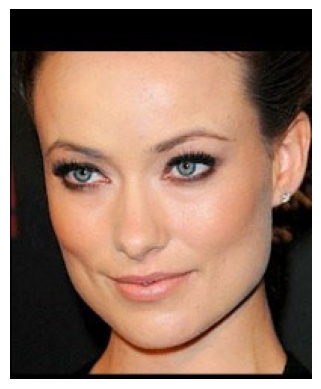

In [9]:
show_img('./Totally-Looks-Like/dataset/train/left/abn.jpg')
train = read_file('./Totally-Looks-Like/dataset/train.csv')

In [14]:
left_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Randomly zoom in on images by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill mode for newly created pixels
)

right_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Randomly zoom in on images by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill mode for newly created pixels
)

# Set the batch size and image size
batch_size = 32
image_size = (200, 245)

# Create generators for "left" and "right" images
left_generator = left_datagen.flow_from_directory(
    './Totally-Looks-Like/dataset/train',  # Path to the "left" image folder
    target_size=image_size,
    batch_size=batch_size,
    class_mode= None       
)

right_generator = right_datagen.flow_from_directory(
    './Totally-Looks-Like/dataset/train', # Path to the "right" image folder
    target_size=image_size,
    batch_size=batch_size,
    class_mode= None    
)


    

Found 4001 images belonging to 2 classes.
Found 4001 images belonging to 2 classes.


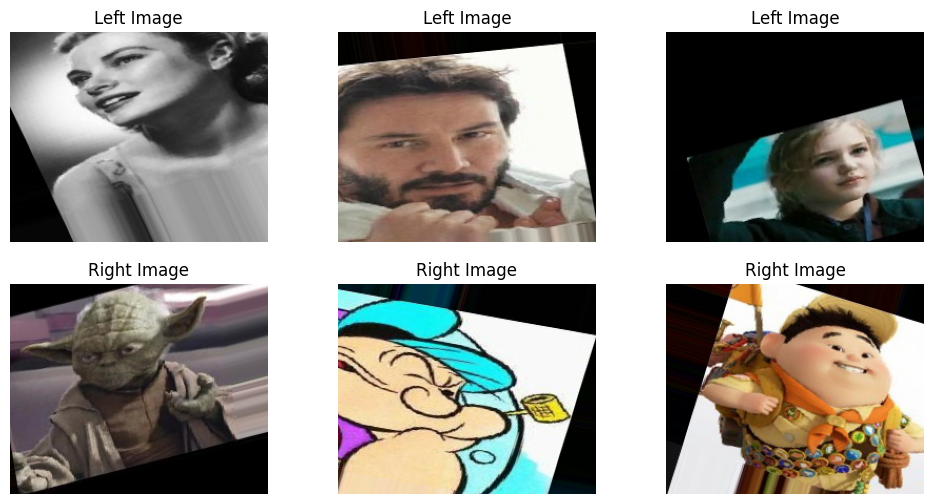

In [15]:
# Get a batch of images from the generators
left_batch= next(left_generator)  # We don't need labels for display
right_batch = next(right_generator)  # We don't need labels for display

# Define the number of images to display
num_images_to_display = 3

# Display a few images from the batch
plt.figure(figsize=(12, 6))

for i in range(num_images_to_display):
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(left_batch[i])
    plt.title("Left Image")
    plt.axis("off")

    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(right_batch[i])
    plt.title("Right Image")
    plt.axis("off")

plt.show()